**Mounting Drive to Virtual Machine.**

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**Extraction of Data.**

In [4]:
import zipfile
zip_ref = zipfile.ZipFile("/content/drive/Shareddrives/Project2022/COVID-19/Dataset/covid.zip", 'r')
zip_ref.extractall("/tmp")
zip_ref.close()

**Importing required Libraries.**

In [5]:
import pandas as pd
import seaborn as sns
from pathlib import Path
import os
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from matplotlib import pyplot as plt, image as img
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import (
    Conv2D,
    Conv2DTranspose,
    MaxPool2D,
    ReLU,
    Flatten,
    Dense,
    UpSampling2D,
)
from tensorflow.keras.models import Model, Sequential
from skimage.transform import resize
from tensorflow import Tensor
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras import layers
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.layers import Input
from tensorflow import Tensor
from scipy.stats import mannwhitneyu
from tabulate import tabulate

!pip install progressbar
import progressbar

# random seed generator
np.random.seed(3)
tf.random.set_seed(7)

  Created wheel for progressbar: filename=progressbar-2.5-py3-none-any.whl size=12082 sha256=9a992adf74cae10447e659923b11b507c8093c2aac63efc875e60aab6654001d
  Stored in directory: /root/.cache/pip/wheels/f0/fd/1f/3e35ed57e94cd8ced38dd46771f1f0f94f65fec548659ed855
Successfully built progressbar


**Loading Data.**

In [ ]:
def load_raw_data():

    covid_path = "/tmp/curated_data/curated_data/2COVID"
    non_covid_path = "/tmp/curated_data/curated_data/1NonCOVID"

    covid_images = list(Path(covid_path).glob("*.png"))
    non_covid_images = list(Path(non_covid_path).glob("*.png"))

    # To visualize the dataset
    fig = plt.figure(figsize=(10, 10))
    fig.add_subplot(1, 2, 1)
    image = img.imread(covid_images[1])
    plt.imshow(image)
    plt.title("CT Scan of Covid Affected Lungs")

    fig.add_subplot(1, 2, 2)
    image = img.imread(non_covid_images[1])
    plt.imshow(image)
    plt.title("CT Scan of Healthy Lungs")
    return covid_images, non_covid_images

**Converting images to numpy arrays.**

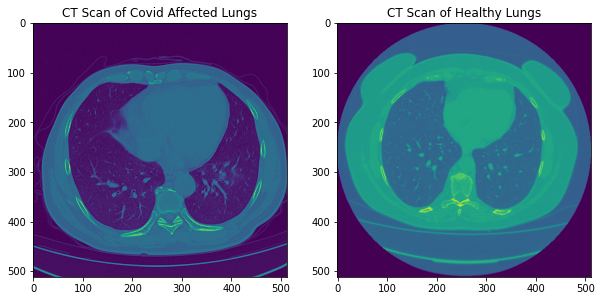

In [ ]:
covid_images, non_covid_images = load_raw_data()
IMG_SIZE = 128

# Two empty numpy arrays to store coverted images
positive_npy = np.empty((len(covid_images), IMG_SIZE, IMG_SIZE, 1), dtype=np.float32)
negative_npy = np.empty((len(non_covid_images), IMG_SIZE, IMG_SIZE, 1), dtype=np.float32)

# start a bar of show percentage of loading data 
covid_bar = progressbar.ProgressBar(maxval=len(covid_images), widgets=[progressbar.Bar('=', '[', ']'), ' ', progressbar.Percentage()])
non_covid_bar = progressbar.ProgressBar(maxval=len(non_covid_images), widgets=[progressbar.Bar('=', '[', ']'), ' ', progressbar.Percentage()])

In [ ]:
covid_bar.start()
# Converting COVID dataset to .npy format
for i, _file in enumerate(covid_images):
    try:
        image_npy = img.imread(_file)
        positive = resize(image_npy, (IMG_SIZE, IMG_SIZE, 1), anti_aliasing=True)
        positive_npy[i] = positive
    except:
        pass
    covid_bar.update(i+1)
    
covid_bar.finish()
print("COVID images converting done")

COVID images converting done


In [ ]:
non_covid_bar.start()
# Converting non-COVID dataset to .npy format
for i, _file in enumerate(non_covid_images):
    try:
        image_npy = img.imread(_file)
        negative = resize(image_npy, (IMG_SIZE, IMG_SIZE, 1), anti_aliasing=True)
        negative_npy[i] = negative
    except:
        print("cant open image " + i + "th") 
        
    non_covid_bar.update(i+1)
non_covid_bar.finish()
print("non covid images converting done") 

non covid images converting done


**Saving above progress in pickle files.**

In [ ]:
import pickle

pickle_out =open( "/content/drive/Shareddrives/Project2022/COVID-19/pickle_files/positive_npy.pickle","wb")
pickle.dump(positive_npy,pickle_out)
pickle_out.close()

pickle_out= open("/content/drive/Shareddrives/Project2022/COVID-19/pickle_files/negative_npy.pickle","wb")
pickle.dump(negative_npy,pickle_out)
pickle_out.close()

**After mounting drive and importing packages
 directly run the below cell to avoid runtime loss of virtual machine.**
 



In [6]:
import pickle

pickle_in = open("/content/drive/Shareddrives/Project2022/COVID-19/pickle_files/positive_npy.pickle","rb")
positive_npy=pickle.load(pickle_in)
pickle_in = open("/content/drive/Shareddrives/Project2022/COVID-19/pickle_files/negative_npy.pickle","rb")
negative_npy=pickle.load(pickle_in)

In [7]:
print(positive_npy.shape)
print(negative_npy.shape)

(7593, 128, 128, 1)
(6893, 128, 128, 1)


In [8]:
# To load dataset and concat them to x and y
def load_data():
    positive = positive_npy
    positive_labels = ["1" for i in positive]
    negative = negative_npy
    negative_labels = ["0" for i in negative]

    # Joining both datasets and labels
    X = np.concatenate([positive, negative])
    y = np.array((positive_labels + negative_labels), dtype=np.float32)
    return X, y

**Convolutional Neural Network Model.**

In [9]:
# CNN model
def cnn():
    model = Sequential()
    # convulutional layer
    model.add(
        Conv2D(
            32,
            kernel_size=5,
            activation="relu",
            input_shape=(128, 128, 1),
        )
    )
    # Normalising after activation
    model.add(BatchNormalization())    
    model.add(MaxPool2D(pool_size=(2, 2)))
    model.add(Conv2D(64, kernel_size=5, activation="relu"))
    model.add(BatchNormalization())
    model.add(MaxPool2D(pool_size=(2, 2)))
    model.add(Conv2D(128, kernel_size=5, activation="relu"))
    model.add(BatchNormalization())
    model.add(MaxPool2D(pool_size=(2, 2)))
    model.add(Conv2D(256, kernel_size=5, activation="relu"))
    model.add(BatchNormalization())
    model.add(MaxPool2D(pool_size=(2, 2)))
    model.add(Flatten())
    # fully connected layer
    model.add(Dense(200, activation="relu"))
    # output
    model.add(Dense(2, activation="softmax"))
    model.compile(
        loss=keras.losses.sparse_categorical_crossentropy,
        optimizer= keras.optimizers.Adam(lr=0.002, beta_1=0.9, beta_2=0.999, epsilon=0.1, decay=0.0),
        metrics=["accuracy"],
    )
    return model

In [10]:
X, y = load_data()
print(X.shape)
print(y.shape)

(14486, 128, 128, 1)
(14486,)


In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model = cnn()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 124, 124, 32)      832       
                                                                 
 batch_normalization (BatchN  (None, 124, 124, 32)     128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 62, 62, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 58, 58, 64)        51264     
                                                                 
 batch_normalization_1 (Batc  (None, 58, 58, 64)       256       
 hNormalization)                                                 
                                                        

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [12]:
history_cnn = model.fit(
    X_train,
    y_train,
    epochs=100,
    workers=4,
    validation_data=(X_test, y_test),
)

Epoch 1/100
363/363 [==============================] - 38s 68ms/step - loss: 0.3309 - accuracy: 0.8683 - val_loss: 1.6345 - val_accuracy: 0.4783
Epoch 2/100
363/363 [==============================] - 23s 64ms/step - loss: 0.2062 - accuracy: 0.9188 - val_loss: 0.2392 - val_accuracy: 0.9099
Epoch 3/100
363/363 [==============================] - 24s 66ms/step - loss: 0.1431 - accuracy: 0.9430 - val_loss: 0.1900 - val_accuracy: 0.9234
Epoch 4/100
363/363 [==============================] - 23s 63ms/step - loss: 0.1020 - accuracy: 0.9601 - val_loss: 0.1562 - val_accuracy: 0.9444
Epoch 5/100
363/363 [==============================] - 23s 63ms/step - loss: 0.0829 - accuracy: 0.9684 - val_loss: 0.1298 - val_accuracy: 0.9555
Epoch 6/100
363/363 [==============================] - 23s 63ms/step - loss: 0.0387 - accuracy: 0.9856 - val_loss: 0.0831 - val_accuracy: 0.9714
Epoch 7/100
363/363 [==============================] - 23s 63ms/step - loss: 0.0270 - accuracy: 0.9902 - val_loss: 0.0969 - val_ac

In [13]:
y_pred = model.predict(X_test)
predicted = np.argmax(y_pred, axis=-1)
accuracy = np.equal(y_test, predicted).mean()
print("Accuracy:", accuracy)

Accuracy: 0.9865424430641822


**Classification Report**

In [14]:
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(y_test, predicted))

              precision    recall  f1-score   support

         0.0       0.98      0.99      0.99      1377
         1.0       0.99      0.98      0.99      1521

    accuracy                           0.99      2898
   macro avg       0.99      0.99      0.99      2898
weighted avg       0.99      0.99      0.99      2898



**Confusion Matrix.**

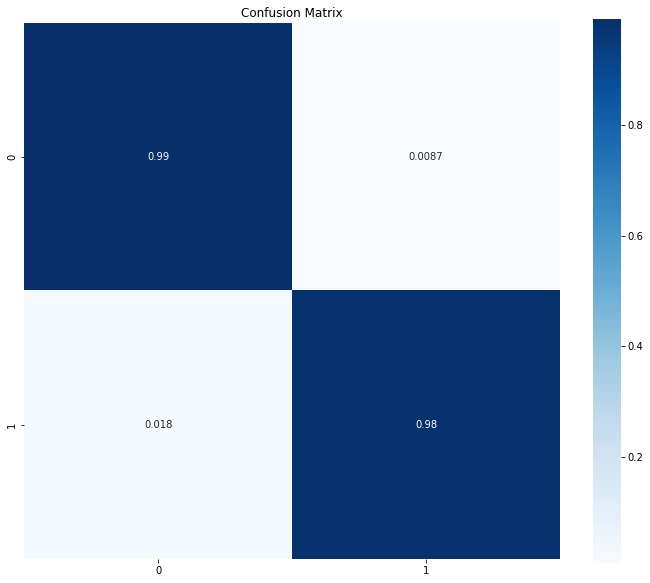

In [15]:
cm = confusion_matrix(y_test, predicted, normalize = 'true')
cm_df = pd.DataFrame(cm)
plt.figure(figsize=(12, 10))
plt.title('Confusion Matrix')
sns.heatmap(cm_df, annot=True, cmap='Blues', square=True);

**Accuracy vs Loss vs Epochs plots.**

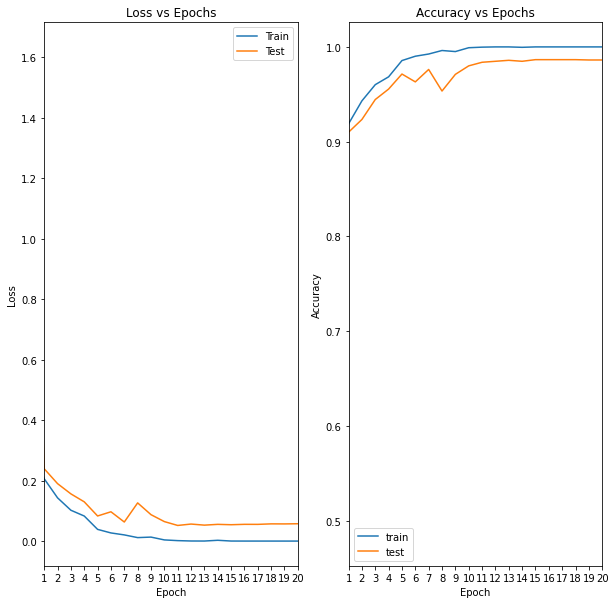

In [16]:
# To plot learning curves
fig, ax = plt.subplots(1, 2, figsize=(10, 10))
ax[0].set_title("Loss vs Epochs")
ax[0].plot(history_cnn.history["loss"])
ax[0].plot(history_cnn.history["val_loss"])
ax[0].legend(["Train", "Test"])
ax[0].set_xlabel("Epoch")
ax[0].set_ylabel("Loss")
ax[0].set_xlim(1, 20)
ax[0].set_xticks(range(1, 21))

ax[1].set_title("Accuracy vs Epochs")
ax[1].plot(history_cnn.history["accuracy"])
ax[1].plot(history_cnn.history["val_accuracy"])
ax[1].legend(["train", "test"])
ax[1].set_xlabel("Epoch")
ax[1].set_ylabel("Accuracy")
ax[1].set_xlim(1, 20)
ax[1].set_xticks(range(1, 21))

plt.show()

**Final Prediction and Report**

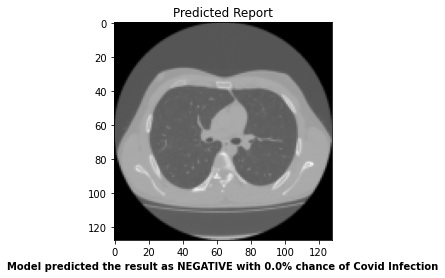

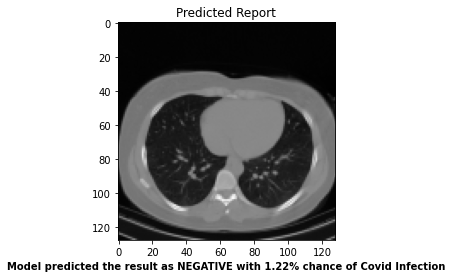

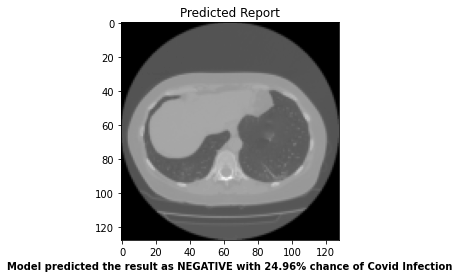

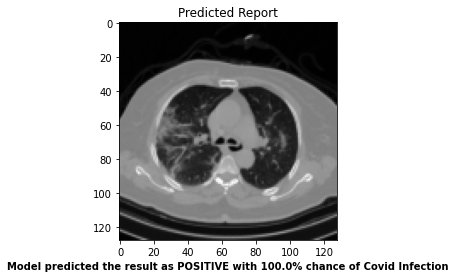

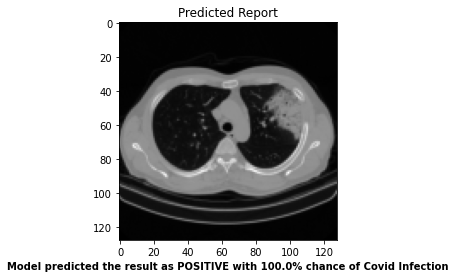

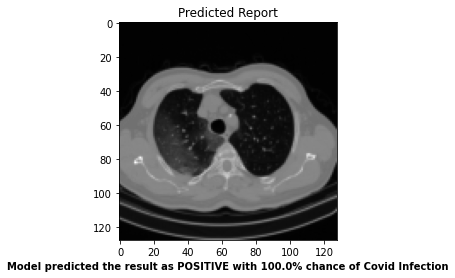

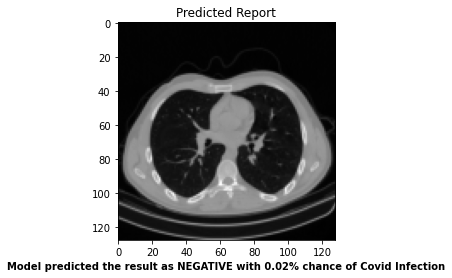

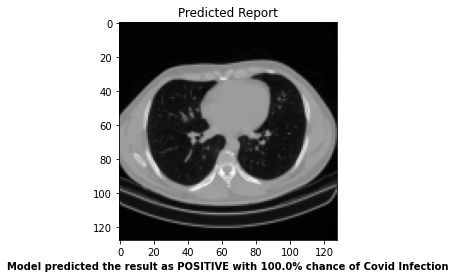

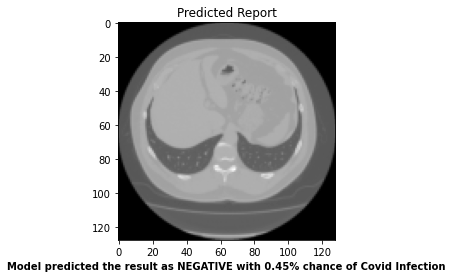

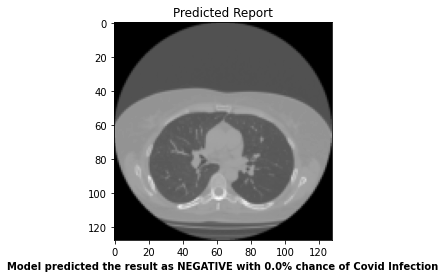

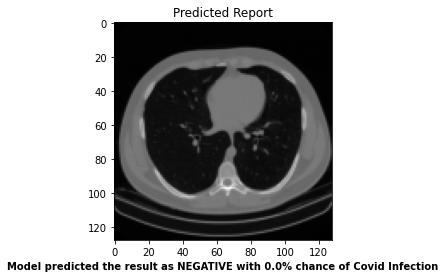

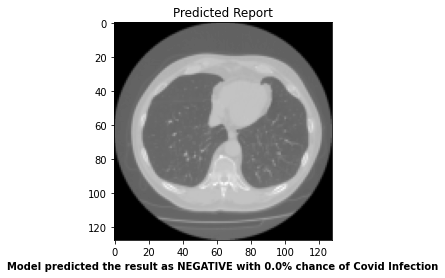

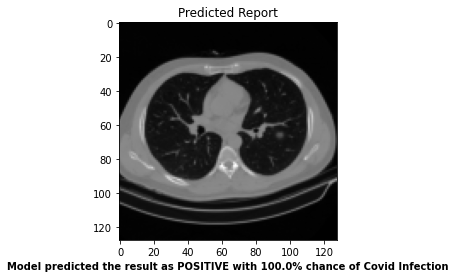

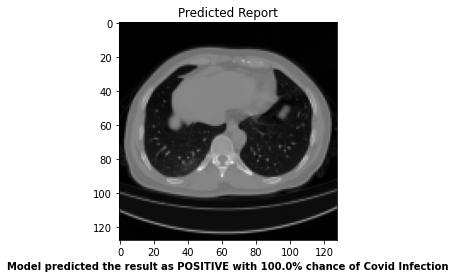

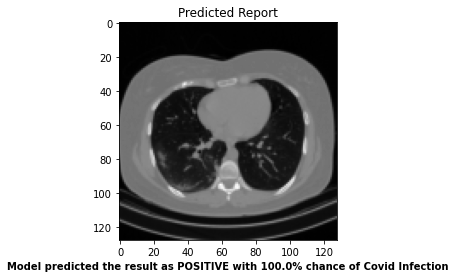

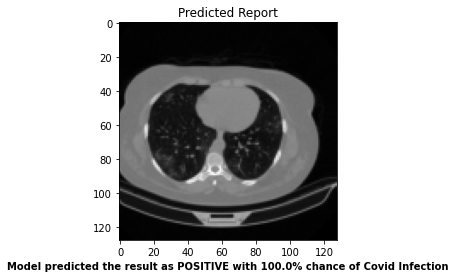

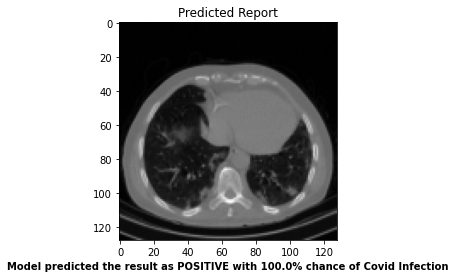

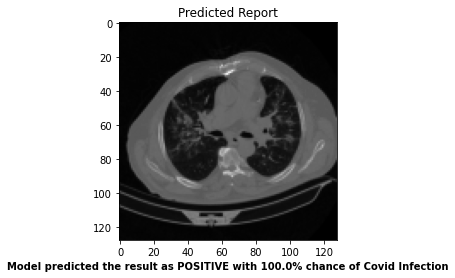

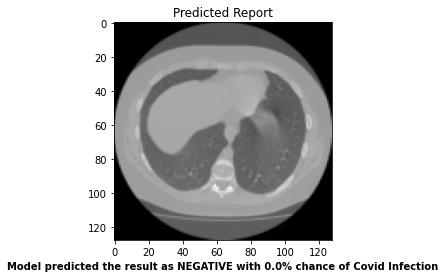

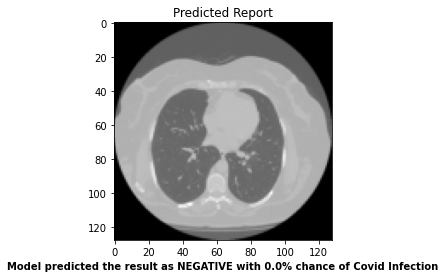

In [17]:
# To print the final report
j = 0
k = 0
for i, label in enumerate(y_pred):

    # Report for positive predicted cases
    if (np.argmax(y_pred[i]) == 1.0) and (j < 10):
        plt.title("Predicted Report")
        plt.imshow(X_test[i].squeeze(), cmap="gray")
        plt.xlabel(
            "Model predicted the result as POSITIVE with "
            + str(round((np.max(label) * 100), 2))
            + "% chance of Covid Infection",
            fontweight="bold",
        )

        plt.show()
        j = j + 1

    # Report for negative predicted cases
    if (np.argmax(y_pred[i]) == 0.0) and (k < 10):
        plt.title("Predicted Report")
        plt.imshow(X_test[i].squeeze(), cmap="gray")
        plt.xlabel(
            "Model predicted the result as NEGATIVE with "
            + str(round((np.min(label) * 100), 2))
            + "% chance of Covid Infection",
            fontweight="bold",
        )
        plt.show()
        k = k + 1
